<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/HW_04_Mini_Project_(seismic_image_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ENR4320 Energy Resources and AI 22251844 이도윤
#HW #04 - Mini-Project (seismic image classification)
## Generator seismic data from machine learning model

# Seismic Image Classification

### 1. Data loading

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from google disk
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/AI Energy/'

# read npy format data
X_syn = np.load(path + 'synth_500_proc.npy')
X_fld = np.load(path + 'field_500_proc.npy')

# print(X_org.shape, Y_org.shape)
print(X_syn.shape)
print(X_fld.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(500, 128, 128)
(500, 128, 128)


500 — number of samples (individual 2D maps/images) <br>
128 — height (rows) of each map <br>
128 — width (columns) of each map

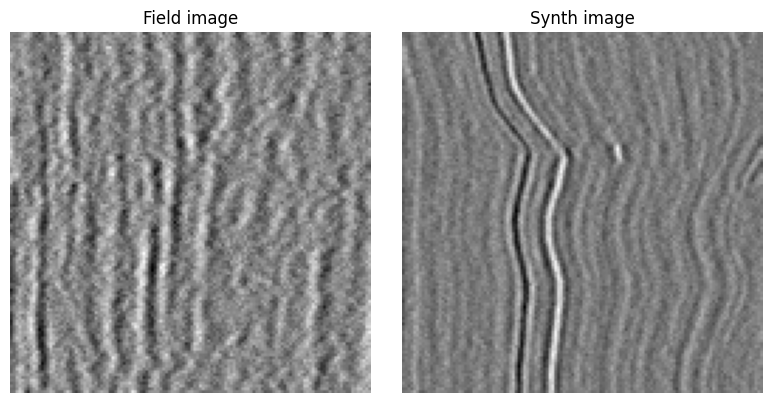

In [9]:
# Visualize some images
data = np.load(path + "field_500_proc.npy") # shape (500,128,128)
i = 0  # index 1 picture from field dataset

data1 = np.load(path + "synth_500_proc.npy") # shape (500,128,128)
i = 0  # index 1 picture from synth dataset

#Plots result
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(data[i], cmap='gray')
axes[0].set_title('Field image')
axes[0].axis('off')

axes[1].imshow(data1[i], cmap='gray')
axes[1].set_title('Synth image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_label_comp(data1, data2, image_index): # function visually compare two 2D images at the same index from different arrays

    fig, axes = plt.subplots(1, 2, figsize=(8, 4)) # 1 row, 2 columns

    # 첫 번째 subplot
    im1 = axes[0].imshow(np.transpose(data1[image_index]), cmap='gray_r', interpolation='none') # 'gray_r'는 흑백 반전 colormap
    axes[0].set_title('seismic image 1')

    # 첫 번째 subplot에 대한 colorbar (세로 크기 동일)
    divider1 = make_axes_locatable(axes[0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    # 두 번째 subplot
    im2 = axes[1].imshow(np.transpose(data2[image_index]), cmap='gray_r', interpolation='none')
    axes[1].set_title('seismic image 2')

    # 두 번째 subplot에 대한 colorbar (세로 크기 동일)
    divider2 = make_axes_locatable(axes[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    plt.tight_layout()
    plt.show()


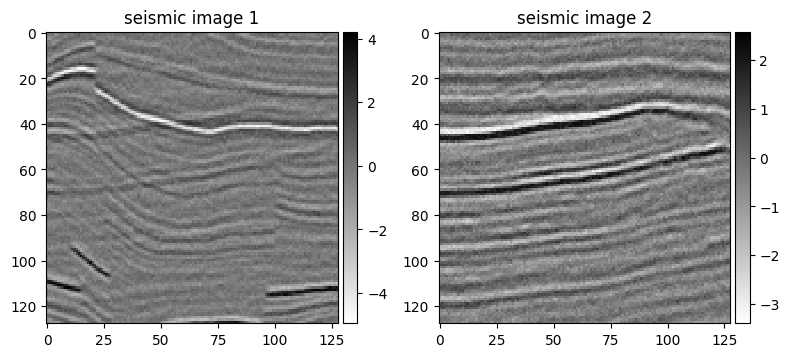

In [12]:
plot_label_comp(X_syn, X_fld, 250) # compare 250-th image from both datasets

# 2. Labels are created from the 2 dataset(synthetic(500) and field(500))

In [17]:
import pandas as pd

# create combine dataset from synthetic and field
def npys_to_table(
    synth_path: str,
    field_path: str,
    save_csv: str = "combined_table.csv",
    feature_names: list[str] | None = None,
    make_numeric_label: bool = True,
    synthetic_name: str = "synthetic",
    field_name: str = "field",
    float_dtype = np.float32,
) -> pd.DataFrame:
    """
    transform 2 .npy file (synthetic и field) in combine dataset:
    [features..., Label(row), Label_id(number, опц.)] save in CSV.

    - forms:
        (N, F) — без изменений
        (N,)   — → (N, 1)
        (N, d1, d2, ...) — → (N, d1*d2*...)
    """
    synth_p, field_p = Path(synth_path), Path(field_path)
    Xs = np.asarray(np.load(synth_p, allow_pickle=True))
    Xf = np.asarray(np.load(field_p, allow_pickle=True))

    # create forms
    def _to_2d(x):
        if x.ndim == 1:
            return x.reshape(-1, 1)
        if x.ndim >= 3:
            return x.reshape(x.shape[0], -1)
        return x
    Xs, Xf = _to_2d(Xs), _to_2d(Xf)

    if Xs.shape[1] != Xf.shape[1]:
        raise ValueError(f"Incompatible feature shapes: {Xs.shape[1]} vs {Xf.shape[1]}")

    # name shapes
    n_features = Xs.shape[1]
    if feature_names is None:
        feature_names = [f"f{i+1:02d}" for i in range(n_features)]  # f01, f02, ...

    # type
    Xs = Xs.astype(float_dtype, copy=False)
    Xf = Xf.astype(float_dtype, copy=False)

    # Tables and string labels
    df_synth = pd.DataFrame(Xs, columns=feature_names)
    df_synth["Label"] = synthetic_name
    df_field = pd.DataFrame(Xf, columns=feature_names)
    df_field["Label"] = field_name

    # union of two datasets.
    df = pd.concat([df_synth, df_field], ignore_index=True)

    #  1=synthetic, 0=field
    if make_numeric_label:
        label_map = {synthetic_name: 1, field_name: 0}
        df["Label_id"] = df["Label"].map(label_map).astype("int64")

    # save
    df.to_csv(save_csv, index=False)
    print(df.head(), "\n")
    print(df["Label"].value_counts(), "\n")
    print(f"Saved -> {save_csv} | shape={df.shape}")

    return df


In [18]:
#  .npy
df = npys_to_table(
    path + "synth_500_proc.npy",
    path + "field_500_proc.npy",
    save_csv="my_dataset_table.csv",
    # name class:
    synthetic_name="synthetic",
    field_name="field",
)

# print check
print(df.dtypes)
print(df["Label"].value_counts())

        f01       f02       f03       f04       f05       f06       f07  \
0 -1.161243 -1.161051 -1.224509 -0.605055 -0.106803  0.137175 -0.327901   
1 -0.181608 -0.473053 -0.433254 -0.129050 -0.355412 -1.105960 -0.600086   
2  0.014300  0.299920  0.285910  0.202444  0.400866  0.687009  0.614435   
3 -1.030151 -0.926235 -0.430353  0.338641  0.894853  0.378457 -0.410774   
4  0.584768 -0.716166 -0.113162 -0.310483 -0.152063 -0.506469 -0.340400   

        f08       f09       f10  ...    f16377    f16378    f16379    f16380  \
0 -0.786394 -1.083652 -0.484977  ... -0.261862 -0.269392 -0.254417 -0.646453   
1  0.563051  0.242252 -0.596080  ... -1.094301 -0.863761 -0.622072 -0.158502   
2  1.027561  0.559329  0.093082  ...  0.367756  0.935271  0.371407 -0.251516   
3 -0.901762 -0.210282 -0.605237  ... -0.356779 -0.694944 -0.302812  0.359104   
4  0.366207 -0.612640 -0.418754  ... -0.383941 -0.119102 -0.071884 -0.446153   

     f16381    f16382    f16383    f16384      Label  Label_id  
0 -

# 3. Split 80%-training data 20%-test data

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

feature_cols = [c for c in df.columns if c not in ("Label", "Label_id")]
X = df[feature_cols].to_numpy(dtype=np.float32)

# y_enc: Label_id (1=synthetic, 0=field)
if "Label_id" in df.columns:
    y_enc = df["Label_id"].to_numpy(dtype=np.int64)
else:

    le = LabelEncoder()
    y_enc = le.fit_transform(df["Label"].to_numpy())
    print("Label mapping:", dict(zip(le.transform(le.classes_), le.classes_)))

# Split 20&80
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.20, stratify=y_enc, random_state=42
)

print(f"Sample size: Training {X_train.shape}, Test {X_test.shape}\n")

# Scale (fit only on train!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled (first 3 rows):\n", X_train_scaled[:3], "\n")

# Check
def dist(y):
    u, c = np.unique(y, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}
print("Class distribution — total:", dist(y_enc))
print("Class distribution — train:", dist(y_train))
print("Class distribution — test :", dist(y_test))

"""
We use train_test_split(*arrays, test_size=None, train_size=None,
random_state=None, shuffle=True, stratify=None) to split data 80/20.
Scaling with StandardScaler (fit on train, transform train/test) for MLP.
"""


Sample size: Training (800, 16384), Test (200, 16384)

Scaled (first 3 rows):
 [[-0.82254714 -0.70085835  0.7189608  ...  1.4364798  -0.03515678
  -1.3215537 ]
 [-1.3915132  -1.1071188  -1.0876507  ... -0.59062827 -0.9707716
  -0.95225453]
 [ 0.07246818 -0.8513171  -1.1919957  ...  0.13350245 -0.7222963
  -0.60677683]] 

Class distribution — total: {0: 500, 1: 500}
Class distribution — train: {0: 400, 1: 400}
Class distribution — test : {0: 100, 1: 100}


'\nWe use train_test_split(*arrays, test_size=None, train_size=None,\nrandom_state=None, shuffle=True, stratify=None) to split data 80/20.\nScaling with StandardScaler (fit on train, transform train/test) for MLP.\n'

# 4. MLP (TensorFlow) training test

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,753 (4.01 MB)

 Trainable params: 1,050,753 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5222 - auc: 0.5324 - loss: 2.0275 - val_accuracy: 0.5875 - val_auc: 0.7155 - val_loss: 0.9951 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7952 - auc: 0.8441 - loss: 0.7122 - val_accuracy: 0.5312 - val_auc: 0.7155 - val_loss: 3.2153 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7666 - auc: 0.8523 - loss: 1.3206 - val_accuracy: 0.5625 - val_auc: 0.7245 - val_loss: 2.2732 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8760 - auc: 0.9246 - loss: 0.6024 - val_accuracy: 0.5875 - val_auc: 0.7403 - val_loss: 1.9127 - learning_rate: 0.0010
Epoch 5/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9536 - auc: 0.9793 - loss: 0.1898
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9524 - auc: 0.9792 - loss: 0.1900 

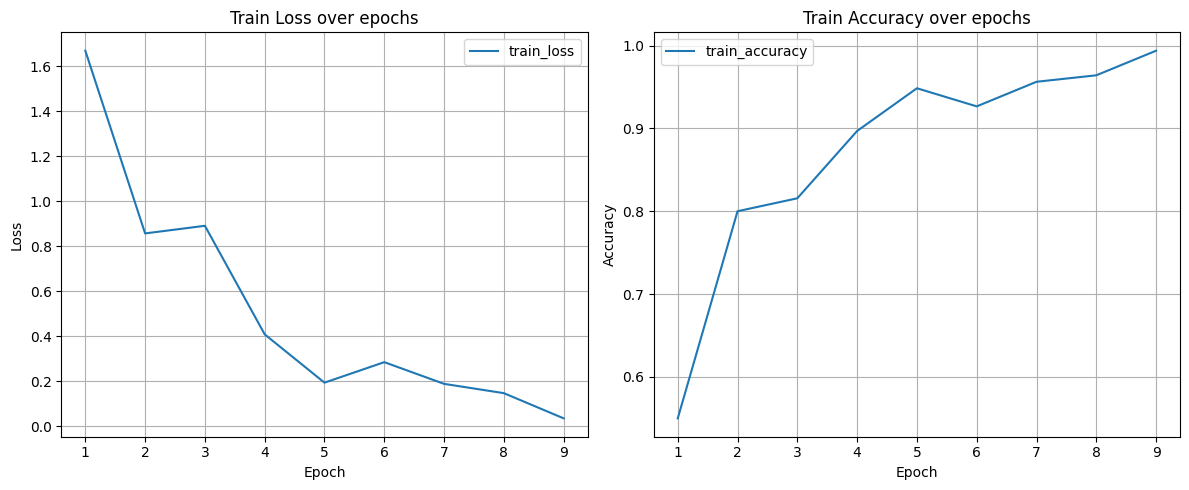

In [24]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


# magic numb for random
tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train_scaled.shape[1]
n_classes  = len(np.unique(y_train))

# hidden
hidden = [64, 32]

# model Sequential
# activation gunction relu
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(n_features,)))
model.add(keras.layers.Dense(hidden[0], activation='relu'))
model.add(keras.layers.Dense(hidden[1], activation='relu'))

# Accuracy
if n_classes == 2:
    # ( 0=field, 1=synthetic)
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    loss = 'binary_crossentropy'
    metrics = ['accuracy', keras.metrics.AUC(name='auc')]
else:
    #
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

model.summary()

# compile
# optimize adam
model.compile(optimizer='adam', loss=loss, metrics=metrics)

# Val Loss
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)
plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1
)

# Training (20%)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, plateau],
    verbose=1
)

# Evaluate
test_metrics = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# plot Loss and accuracy
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='train_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train Loss over epochs')
plt.legend(); plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, hist['accuracy'], label='train_accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Train Accuracy over epochs')
plt.legend(); plt.grid(True)


plt.tight_layout()
plt.show()


model.save('mlp_classifier.keras')

#5. Estimate model (confusion matrix)

      loss: 0.8037
compile_metrics: 0.6250

Classification Report (MLP):
              precision    recall  f1-score   support

       field     0.5786    0.9200    0.7104       100
   synthetic     0.8049    0.3300    0.4681       100

    accuracy                         0.6250       200
   macro avg     0.6917    0.6250    0.5893       200
weighted avg     0.6917    0.6250    0.5893       200

ROC-AUC: 0.7350
Confusion Matrix (counts):
 [[92  8]
 [67 33]]


<Figure size 600x500 with 0 Axes>

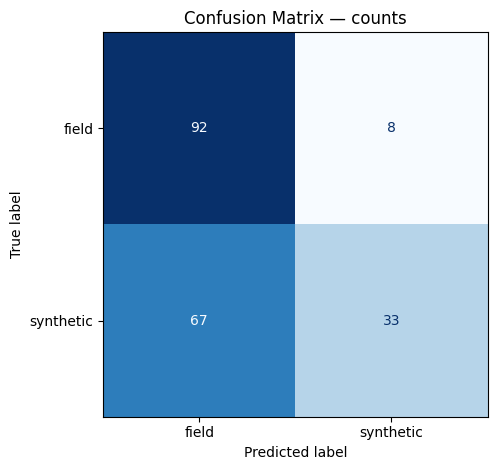

<Figure size 600x500 with 0 Axes>

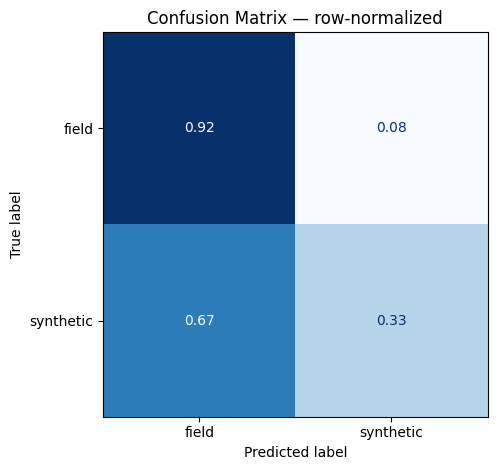

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

test_results = model.evaluate(X_test_scaled, y_test, verbose=0)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name:>10s}: {value:.4f}")

# Извлечём loss/accuracy для отдельной строки (если присутствуют)
test_loss = test_results[model.metrics_names.index("loss")]
test_acc  = test_results[model.metrics_names.index("accuracy")] \
            if "accuracy" in model.metrics_names else None
if test_acc is not None:
    print(f"\nTest — loss: {test_loss:.4f} | accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# 5.2 Предсказания
proba = model.predict(X_test_scaled, verbose=0)
if n_classes == 2:
    y_pred = (proba.ravel() >= 0.5).astype(int)
else:
    y_pred = proba.argmax(axis=1)

# 5.3 Отчёт по классам
# Имена классов: если у вас известны человекочитаемые имена — замените
classes_sorted = sorted(np.unique(y_enc))
target_names = ["field", "synthetic"] if n_classes == 2 else [str(c) for c in classes_sorted] # Assuming 0=field, 1=synthetic for binary case
print("\nClassification Report (MLP):")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# ROC-AUC для бинарного случая
if n_classes == 2:
    auc = roc_auc_score(y_test, proba.ravel())
    print(f"ROC-AUC: {auc:.4f}")

# 5.4 Матрица ошибок (counts)
cm = confusion_matrix(y_test, y_pred, labels=classes_sorted)
print("Confusion Matrix (counts):\n", cm)

plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names or classes_sorted)\
    .plot(cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix — counts")
plt.tight_layout(); plt.show()

# 5.5 Нормированная по строкам матрица (доли)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names or classes_sorted)\
    .plot(cmap="Blues", values_format=".2f", colorbar=False)
plt.title("Confusion Matrix — row-normalized")
plt.tight_layout(); plt.show()

#6. Result

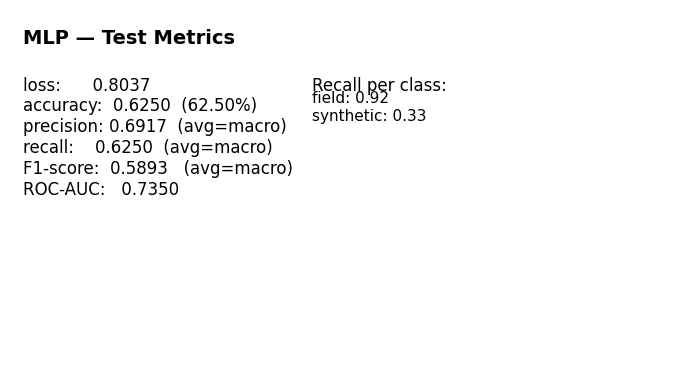

In [27]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)

def plot_metrics_board(
    y_true,
    y_pred,
    loss_value: float,
    proba=None,
    average: str = "macro",
    title: str = "Test Metrics",
    target_names=None,
    savepath: str = None
):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)


    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1   = f1_score(y_true, y_pred, average=average, zero_division=0)


    auc_val = None
    if proba is not None:
        proba = np.asarray(proba)
        classes = np.unique(y_true)
        if classes.size == 2:

            if proba.ndim == 2 and proba.shape[1] == 2:
                pos = proba[:, 1]
            else:
                pos = proba.ravel()
            auc_val = roc_auc_score(y_true, pos)


    fig = plt.figure(figsize=(7, 4))
    ax = plt.gca()
    ax.axis("off")

    lines = [
        f"loss:      {loss_value:.4f}",
        f"accuracy:  {acc:.4f}  ({acc*100:.2f}%)",
        f"precision: {prec:.4f}  (avg={average})",
        f"recall:    {rec:.4f}  (avg={average})",
        f"F1-score:  {f1:.4f}   (avg={average})",
    ]
    if auc_val is not None:
        lines.append(f"ROC-AUC:   {auc_val:.4f}")

    text = "\n".join(lines)
    ax.text(0.02, 0.95, title, fontsize=14, fontweight="bold", va="top")
    ax.text(0.02, 0.82, text, fontsize=12, va="top")


    classes = np.unique(y_true)
    if target_names is None:
        labels = [str(c) for c in classes]
    else:
        labels = list(target_names)


    per_class_recalls = []
    for c in classes:
        tp = np.sum((y_true == c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        per_class_recalls.append(r)

    pc_lines = [f"{lbl}: {r:.2f}" for lbl, r in zip(labels, per_class_recalls)]
    ax.text(0.45, 0.82, "Recall per class:", fontsize=12, va="top")
    ax.text(0.45, 0.78, "\n".join(pc_lines), fontsize=11, va="top")

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

plot_metrics_board(
    y_true=y_test,
    y_pred=y_pred,
    loss_value=test_loss,
    proba=proba,
    average="macro",
    title="MLP — Test Metrics",
    target_names=["field","synthetic"],
    savepath=None
)


# 모델 평가 요약


*   정확도(Accuracy) ≈ 62.5%(bad model)
*   재현율(Recall)
Field : 0.92 → 거의 모든 실제 데이터를 잘 인식함
Synthetic : 0.33 → 합성 데이터를 대부분 놓침

*  ROC-AUC = 0.735 → 실제와 합성 데이터를 어느 정도 구분할 수 있으나, 경계가 불안정함
*   Loss = 0.80 → 학습이 완전히 수렴하지 않았으며, 예측의 변동성이 큼

모델은 실제(field) 데이터에는 과적합(overfitting) 되어 있고, 합성(synthetic) 데이터를 일관성 있게 인식하지 못함.
데이터 생성(generator)용 모델로는 아직 신뢰도 부족.
단순 분류나 데이터 품질 판별(diagnostic filter)에는 사용할 수 있지만,
지진파(EM/Seismic) 데이터 생성용 기반모델로는 안정화 필요.

